In [1]:
import glob
import os
import omegaconf

import pandas as pd

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [2]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/imagen/participants.csv"
embeddings_subpath = "imagen_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/IHI_imagen_without_residualization.csv"
label = "IHI_L"
max_iter = 2000
cv = 5

In [3]:
participants = pd.read_csv(participants_file, index_col=0)
participants[label] = (participants["SCi_L"]>3.75).astype(int)
participants = participants[participants["SCi_R"]<3.75]
participants.head()

,Comments,C0_L,C1_L,C2_L,C3_L,C4_L,C5_L,SCi_L,C0_R,C1_R,...,RAcc,Age for timestamp,Age for processed_timestamp,ni_mass,ni_height,Gender,Handedness,ImagingCentreID,ImagingCentreCity,IHI_L
Subject,,,,,,,,,,,,,,,,,,,,,
1274,NaN,N,0.5,1.0,1.0,0,0.0,2.5,N,0.5,...,331.611335,5487.0,5487.0,50.0,154.0,Female,Right,2,NOTTINGHAM,0
22453,NaN,N,1.0,0.0,0.5,0,0.0,1.5,N,1.0,...,407.934579,NaN,NaN,76.0,172.0,Male,Right,8,DRESDEN,0
75717,NaN,N,0.0,1.0,0.5,0,0.0,1.5,Y,1.5,...,410.603915,5395.0,5395.0,61.0,171.0,Male,Right,2,NOTTINGHAM,0
106601,NaN,N,0.0,0.5,1.0,0,0.0,1.5,N,0.0,...,546.105969,5098.0,5098.0,50.0,162.0,Male,Left,7,PARIS,0
106871,NaN,N,0.0,0.5,0.0,0,0.0,0.5,N,0.5,...,450.044053,5720.0,5720.0,47.0,161.0,Female,Right,8,DRESDEN,0


array([[<Axes: title={'center': 'SCi_L'}>]], dtype=object)

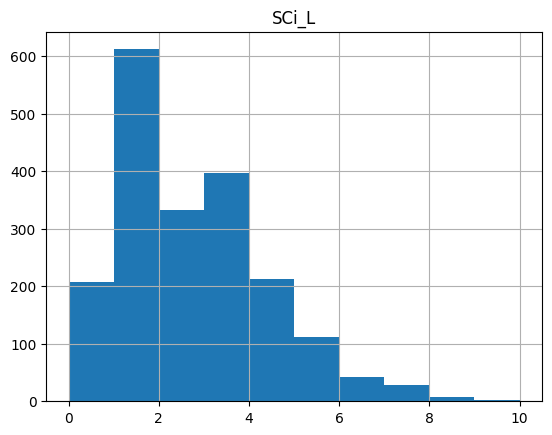

In [4]:
participants[["SCi_L"]].hist()

array([[<Axes: title={'center': 'IHI_L'}>]], dtype=object)

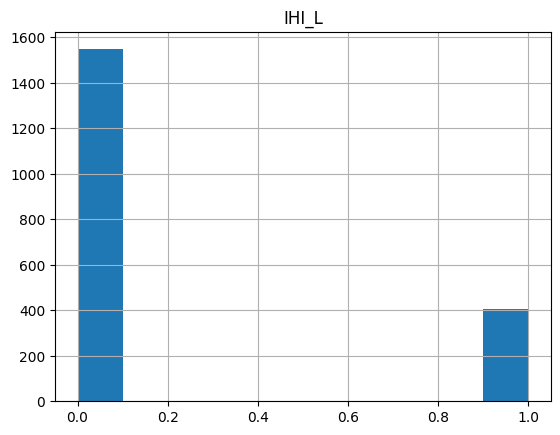

In [5]:
participants[[label]].hist()

In [6]:

participants = participants[[label]].dropna()
participants = participants.replace({"N": 0, "?": 2, "Y": 2})
participants[label].unique()
participants

,IHI_L
Subject,
1274,0
22453,0
75717,0
106601,0
106871,0
...,...
99873252,0
99875982,0
99888850,0


In [7]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [8]:
model_paths = get_model_paths(path_champollion)

In [9]:
model_paths

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STs-SGSM_left/13-57-40_59',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_right/11-43-38_3',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_right/13-19-08_28',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/Lobule_parietal_sup_left/09-48-31_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFint-SR_left/09-00-43_0',
 '/neurospin/dico/data/deep_folding/curren

In [10]:
def compute(model_path):
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop(label, axis=1)
    Y = merged[label]
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    model = LogisticRegression(max_iter=max_iter, random_state=1)
    res = cross_val_score(model, X, Y, cv=cv, scoring='roc_auc')
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(res)
    
    # Returns result
    return (region, res.mean(), res.std(), model_name, region_path, model_path)

In [11]:
result = []
for model_path in model_paths:
    result.append(compute(model_path))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
[0.4527587  0.50121859 0.46565983 0.52027648 0.4948923 ]
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
[0.43053911 0.50984858 0.47768588 0.44636222 0.51936174]
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
[0.55260873 0.49007152 0.50797075 0.53581845 0.49208109]
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
[0.51570763 0.4511167  0.5205162  0.50988853 0.55848115]
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
[0.628

In [12]:
df = pd.DataFrame(result, columns=['region', 'roc_auc', 'roc_auc_std', 'model_name', 'region_path', 'model_path'])

In [13]:
df

,region,roc_auc,roc_auc_std,model_name,region_path,model_path
0,S.C.-sylv._left,0.486961,0.024493,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,0.476760,0.034557,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,0.515710,0.024663,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,0.511142,0.034509,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,0.624391,0.045076,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
93,S.C.-S.Po.C._left,0.500399,0.033351,16-46-17_3,SC-SPoC_left/16-46-17_3,/neurospin/dico/data/deep_folding/current/mode...
94,S.C.-S.Po.C._left,0.500666,0.034911,16-46-17_0,SC-SPoC_left/16-46-17_0,/neurospin/dico/data/deep_folding/current/mode...
95,S.C.-S.Po.C._left,0.502478,0.021092,14-55-36_0,SC-SPoC_left/14-55-36_0,/neurospin/dico/data/deep_folding/current/mode...
96,S.C.-S.Po.C._left,0.494869,0.021971,16-46-17_1,SC-SPoC_left/16-46-17_1,/neurospin/dico/data/deep_folding/current/mode...


In [14]:
df['side'] = df['region'].str.split('_').str[-1]

In [15]:
def plot_horizontal(res, region_name, ax, AUC_name, std_auc_name, AUC2_name, std_auc2_name, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=AUC_name, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=0.5, color='black', linestyle='-')
    ax.barh(res[region_name], res[AUC2_name], fill=True, color='lightgray')
    ax.errorbar(res[AUC_name], res[region_name], xerr=res[std_auc_name], fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    ax.set_xlim((0.45, 0.85))
    ax.set_title(title)


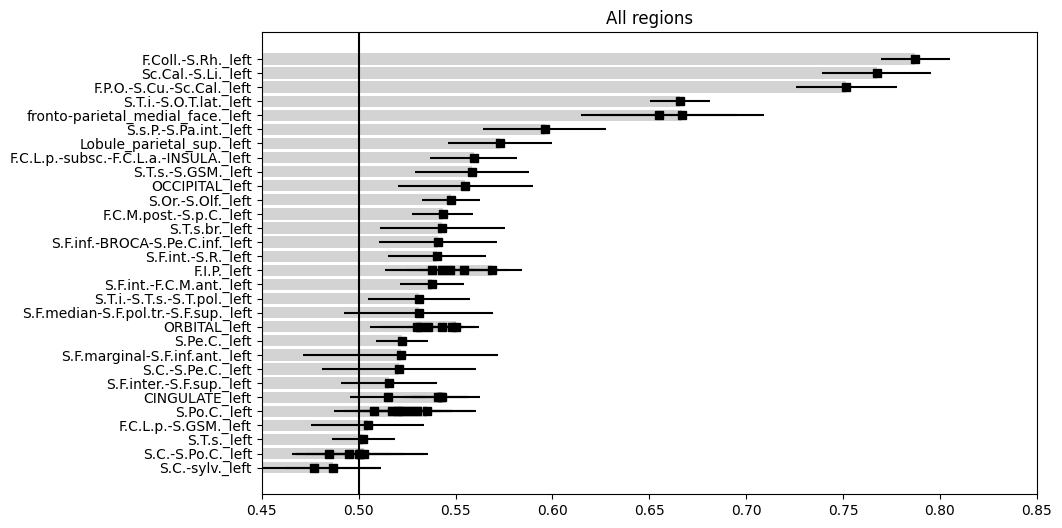

In [16]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

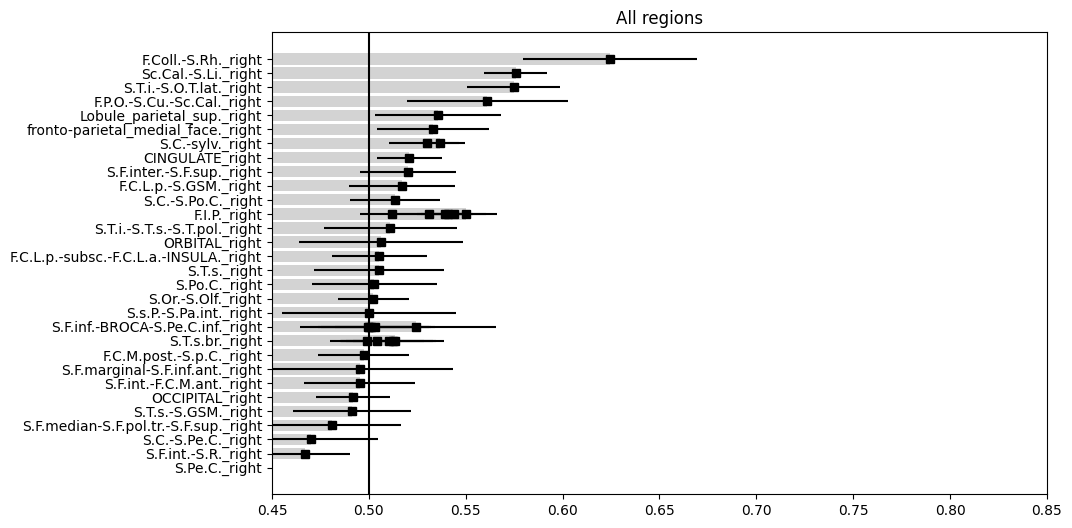

In [17]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

In [18]:
df.to_csv(output_filename)